In [76]:
import os
from pathlib import Path

import numpy as np
from tqdm.notebook import trange
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline
from dpipe.io import load, choose_existing
from dpipe.torch import load_model_state

from ttt_lib.q_learning import PolicyPlayer, play_game, train_q_learning, play_duel
from ttt_lib.torch.module.policy_net import PolicyNetworkRandom, PolicyNetworkQ10Light
from ttt_lib.field import Field
from ttt_lib.utils import choose_model

In [2]:
Q_EXP_PATH = choose_existing(
    Path('/nmnt/x4-hdd/experiments/rl/q_10x10'),
)

os.listdir(Q_EXP_PATH)

['q2_light', 'q8_test', 'q1_light', 'q4_test', 'q2_test', 'q6_test']

# Visualization

In [89]:
exp_path = Q_EXP_PATH / 'q8_test'

In [90]:
device = 'cpu'
n = 10
kernel_len = 5
cnn_features = (128, 64)

field = Field(n=n, kernel_len=kernel_len, device=device, check_device=device)
model = PolicyNetworkQ10Light(n=n, structure=cnn_features)
load_model_state(model, exp_path / choose_model(exp_path))

eps = 0
player = PolicyPlayer(model=model, field=field, eps=eps, device=device)
player.eval()

In [91]:
s_history, f_history, a_history, q_history, q_max_history, p_history, value\
    = play_game(player=player, train=False, augm=False)

In [7]:
# code to visualise (s, a) sequence

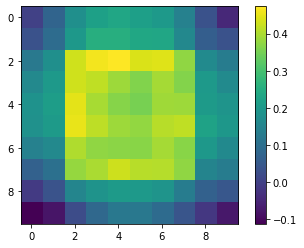

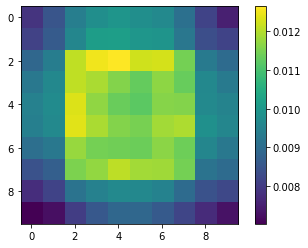

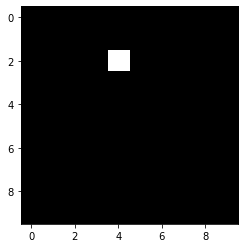

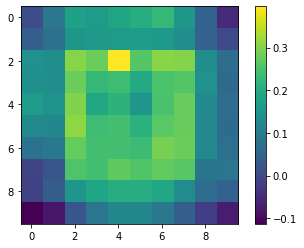

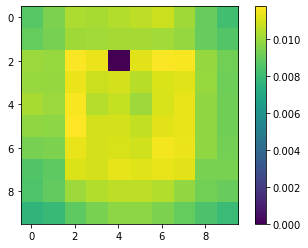

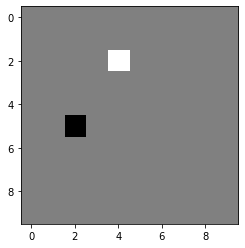

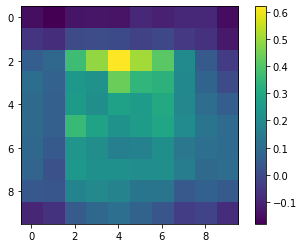

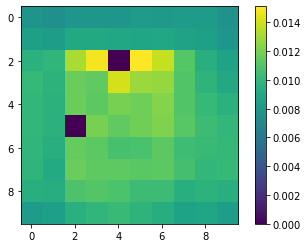

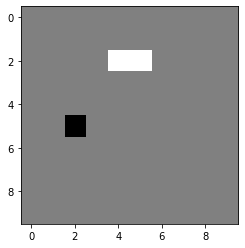

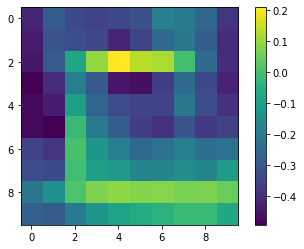

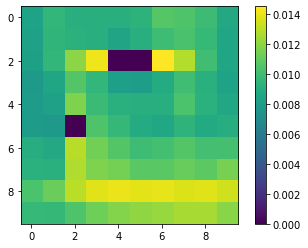

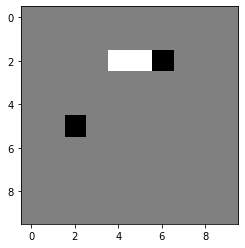

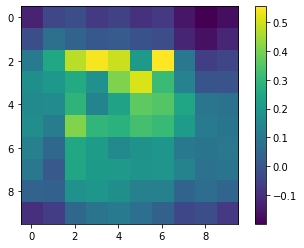

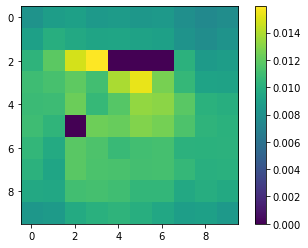

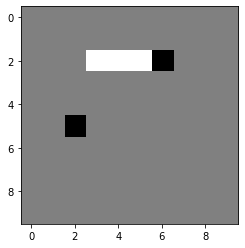

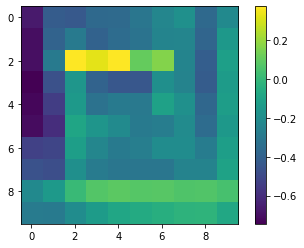

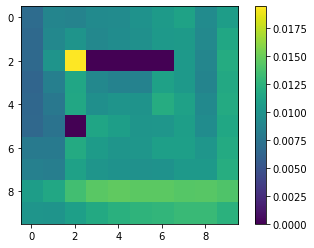

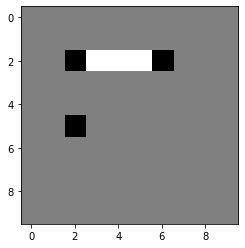

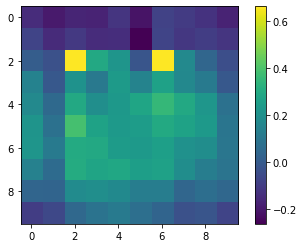

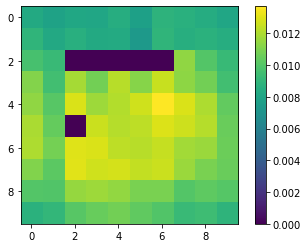

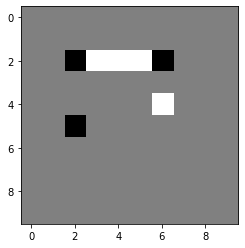

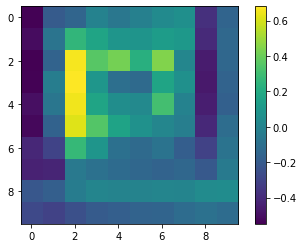

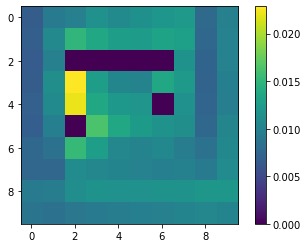

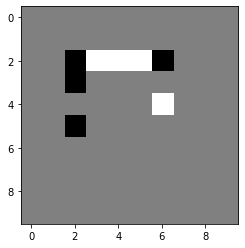

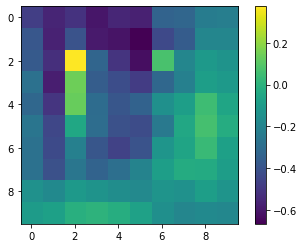

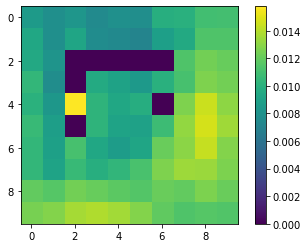

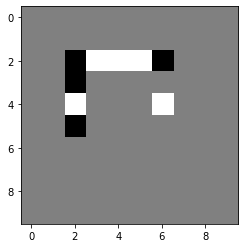

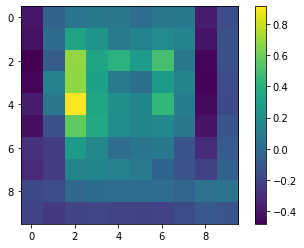

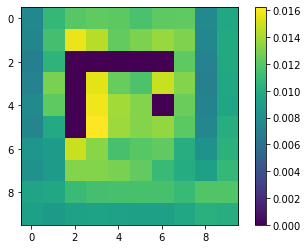

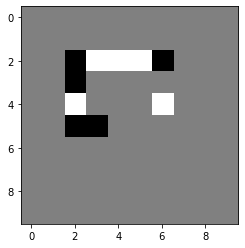

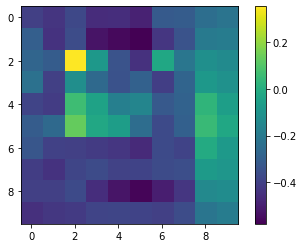

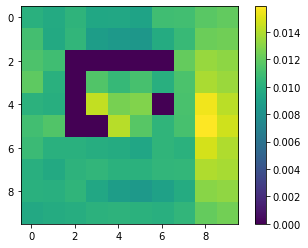

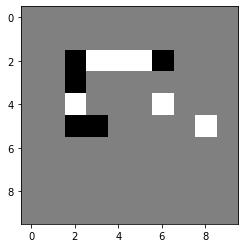

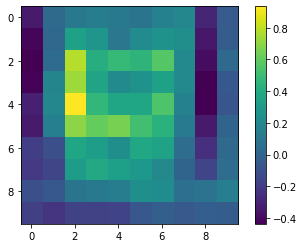

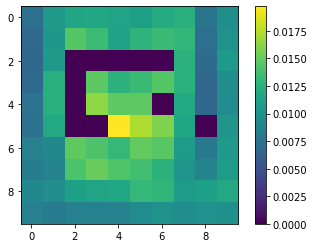

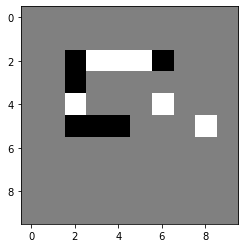

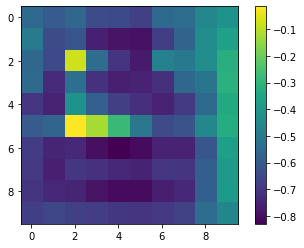

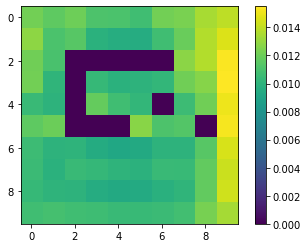

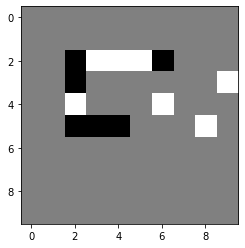

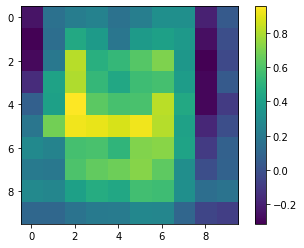

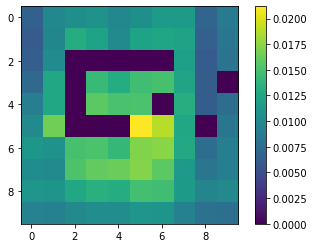

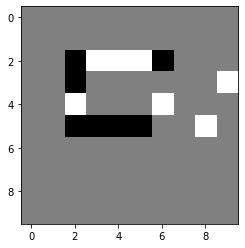

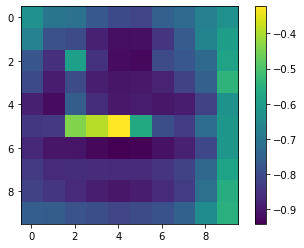

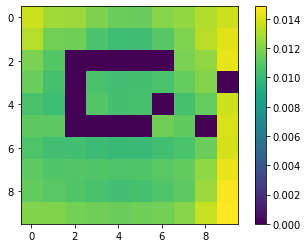

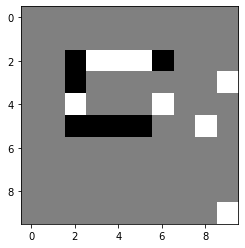

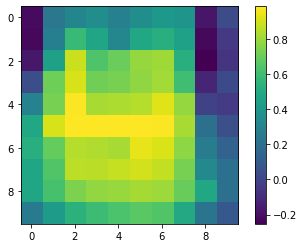

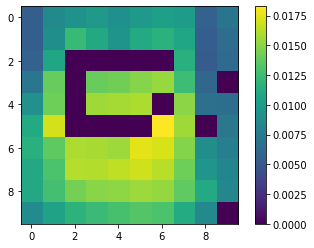

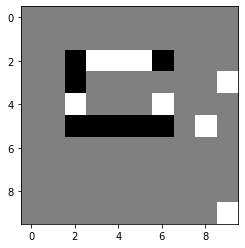

In [92]:
field_v = Field(n, kernel_len)
for s, a, q, p in zip(s_history, a_history, q_history, p_history):
    plt.imshow(q.detach().numpy())
    plt.colorbar()
    plt.show()
    
    plt.imshow(p.detach().numpy())
    plt.colorbar()
    plt.show()

    i, j = a // n, a % n
    field_v.set_state(s)
    field_v.make_move(i, j)
    field_v.show_field()

## Check some manual games

In [7]:
player.update_field(np.zeros((n, n), dtype='float32'))

### Algorithm's policy w/o move

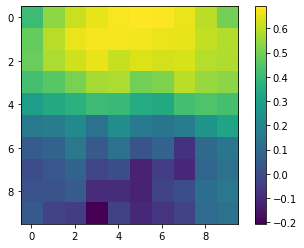

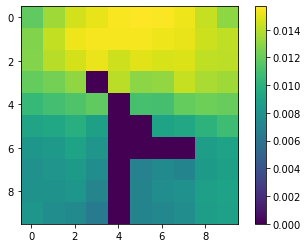

tensor(0) tensor(5)


In [23]:
q, p = player.forward_state()

plt.imshow(q.detach().cpu().numpy())
plt.colorbar()
plt.show()

plt.imshow(p.detach().cpu().numpy())
plt.colorbar()
plt.show()

a = p.argmax()
print(a // n, a % n)

### Algorithm's move

None


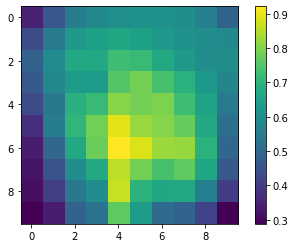

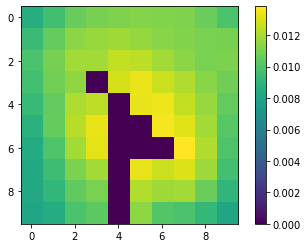

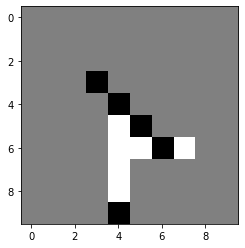

In [22]:
q, p, a, v = player.action(train=False)

print(v)

plt.imshow(q.detach().cpu().numpy())
plt.colorbar()
plt.show()

plt.imshow(p.detach().cpu().numpy())
plt.colorbar()
plt.show()

player.field.show_field()

### Manual move

None


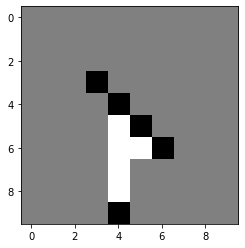

In [21]:
_, _, _, v = player.manual_action(6, 6)

print(v)

player.field.show_field()

## Duel vs random

In [74]:
field_duel = Field(n=n, kernel_len=kernel_len, device=device, check_device=device)

eps = 0.2

player_model_2 = PolicyPlayer(model=PolicyNetworkQ10Light(n=n, structure=cnn_features),
                              field=field_duel, eps=eps, device=device)
path2 = Path('/nmnt/x4-hdd/experiments/rl/q_10x10/q2_test')
load_model_state(player_model_2.model, path2 / choose_model(path2))

player_model_4 = PolicyPlayer(model=PolicyNetworkQ10Light(n=n, structure=cnn_features),
                              field=field_duel, eps=eps, device=device)
path4 = Path('/nmnt/x4-hdd/experiments/rl/q_10x10/q4_test')
load_model_state(player_model_4.model, path4 / choose_model(path4))


player_model_6 = PolicyPlayer(model=PolicyNetworkQ10Light(n=n, structure=cnn_features),
                              field=field_duel, eps=eps, device=device)
path6 = Path('/nmnt/x4-hdd/experiments/rl/q_10x10/q6_test')
load_model_state(player_model_6.model, path6 / choose_model(path6))

player_model_8 = PolicyPlayer(model=PolicyNetworkQ10Light(n=n, structure=cnn_features),
                              field=field_duel, eps=eps, device=device)
path8 = Path('/nmnt/x4-hdd/experiments/rl/q_10x10/q8_test')
load_model_state(player_model_8.model, path8 / choose_model(path8))

model_random = PolicyNetworkRandom(n=n)
player_random = PolicyPlayer(model=model_random, field=field_duel, eps=1., device=device)

In [77]:
res_6_8, res_8_6 = [], []
for _ in trange(100):
    sh, fh, ah, qh, ph, w = play_duel(player_model_6, player_model_8, return_result_only=False)
    res_6_8.append(w)
    
    sh, fh, ah, qh, ph, w = play_duel(player_model_8, player_model_6, return_result_only=False)
    res_8_6.append(w)

In [78]:
print(np.mean(np.array(res_6_8) == 1))
print(np.mean(np.array(res_6_8) == 0))
print(np.mean(np.array(res_6_8) == -1))

0.48
0.0
0.52


In [79]:
print(np.mean(np.array(res_8_6) == 1))
print(np.mean(np.array(res_8_6) == 0))
print(np.mean(np.array(res_8_6) == -1))

0.66
0.0
0.34


In [80]:
res_4_8, res_8_4 = [], []
for _ in trange(100):
    sh, fh, ah, qh, ph, w = play_duel(player_model_4, player_model_8, return_result_only=False)
    res_4_8.append(w)
    
    sh, fh, ah, qh, ph, w = play_duel(player_model_8, player_model_4, return_result_only=False)
    res_8_4.append(w)

In [81]:
print(np.mean(np.array(res_4_8) == 1))
print(np.mean(np.array(res_4_8) == 0))
print(np.mean(np.array(res_4_8) == -1))

0.46
0.0
0.54


In [82]:
print(np.mean(np.array(res_8_4) == 1))
print(np.mean(np.array(res_8_4) == 0))
print(np.mean(np.array(res_8_4) == -1))

0.81
0.0
0.19


In [86]:
res_4_6, res_6_4 = [], []
for _ in trange(100):
    sh, fh, ah, qh, ph, w = play_duel(player_model_4, player_model_6, return_result_only=False)
    res_4_6.append(w)
    
    sh, fh, ah, qh, ph, w = play_duel(player_model_6, player_model_4, return_result_only=False)
    res_6_4.append(w)

In [87]:
print(np.mean(np.array(res_4_6) == 1))
print(np.mean(np.array(res_4_6) == 0))
print(np.mean(np.array(res_4_6) == -1))

0.24
0.0
0.76


In [88]:
print(np.mean(np.array(res_6_4) == 1))
print(np.mean(np.array(res_6_4) == 0))
print(np.mean(np.array(res_6_4) == -1))

0.72
0.0
0.28


In [93]:
a = np.random.poisson(lam=8, size=10000)

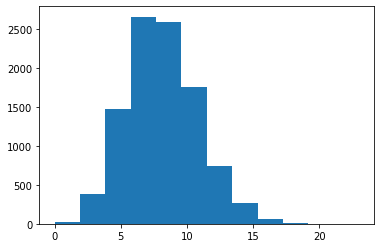

In [94]:
plt.hist(a, bins=12);

In [39]:
a

array([1, 2, 0, ..., 4, 2, 6])

In [73]:
np.random.poisson(lam=3)

0